2nd round of calibration measurements

    IPTS-22666
    168945 - 169105

In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/SEQUOIA/

/SNS/users/lj7/dv/sns-chops/resolution/SEQUOIA


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import os, glob, numpy as np
import mantid.simpleapi as msa
from mantid import mtd
import scipy
import subprocess as sp
import pickle as pkl

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
instrument = 'SEQ'
IPTS = 22666

In [4]:
%matplotlib notebook

In [5]:
# ls /SNS/SEQ//IPTS-21308/nexus/

In [6]:
# ls /SNS/SEQ/IPTS-21308/shared/autoreduce/

In [7]:
# cat /SNS/SEQ/IPTS-21308/shared/autoreduce/experiment_log.csv

In [5]:
RunNumbers=range(168945, 169105+1)
print(RunNumbers)
rawdatadir = "/SNS/%s/IPTS-%s/nexus" % (instrument, IPTS)
autoreducedir = "/SNS/%s/IPTS-%s/shared/autoreduce/" % (instrument, IPTS)

[168945, 168946, 168947, 168948, 168949, 168950, 168951, 168952, 168953, 168954, 168955, 168956, 168957, 168958, 168959, 168960, 168961, 168962, 168963, 168964, 168965, 168966, 168967, 168968, 168969, 168970, 168971, 168972, 168973, 168974, 168975, 168976, 168977, 168978, 168979, 168980, 168981, 168982, 168983, 168984, 168985, 168986, 168987, 168988, 168989, 168990, 168991, 168992, 168993, 168994, 168995, 168996, 168997, 168998, 168999, 169000, 169001, 169002, 169003, 169004, 169005, 169006, 169007, 169008, 169009, 169010, 169011, 169012, 169013, 169014, 169015, 169016, 169017, 169018, 169019, 169020, 169021, 169022, 169023, 169024, 169025, 169026, 169027, 169028, 169029, 169030, 169031, 169032, 169033, 169034, 169035, 169036, 169037, 169038, 169039, 169040, 169041, 169042, 169043, 169044, 169045, 169046, 169047, 169048, 169049, 169050, 169051, 169052, 169053, 169054, 169055, 169056, 169057, 169058, 169059, 169060, 169061, 169062, 169063, 169064, 169065, 169066, 169067, 169068, 169069,

# gather data
**This can be skipped the 2nd time running this notebook**

In [6]:
! find /SNS/{instrument}/IPTS-{IPTS}/shared/autoreduce/ -name SEQ_169105*

/SNS/SEQ/IPTS-22666/shared/autoreduce/SEQ_169105_autoreduced.nxspe
/SNS/SEQ/IPTS-22666/shared/autoreduce/SEQ_169105_autoreduced.nxs
/SNS/SEQ/IPTS-22666/shared/autoreduce/reduction_log/SEQ_169105.nxs.h5.log
/SNS/SEQ/IPTS-22666/shared/autoreduce/powder/SEQ_169105_autoreduced_powder.nxspe


In [7]:
!mkdir -p V-analysis
outdir = 'V-analysis'

In [9]:
# RunParams['SpeedRequest3'].value
# RunParams['frequency'].value
# RunParams.keys()

In [8]:
%matplotlib inline

Took 20 min

In [9]:
%%time
data_table = {}

for RunNumber in RunNumbers:
    print (RunNumber)
    w=msa.CreateSingleValuedWorkspace()
    msa.LoadNexusLogs(w,os.path.join(rawdatadir, "%s_%s.nxs.h5" % (instrument, RunNumber)))
    RunParams=w.getRun()
    # get chopper choice
    chtrans = RunParams['chtrans'].getStatistics().mean
    if chtrans<-400: 
        chopper_choice="highres"
    elif chtrans>0: 
        chopper_choice="highflux"
    else: 
        chopper_choice="none"

    Energy = RunParams["EnergyRequest"].getStatistics().mean
    # generate a nice 2D multi-dimensional workspace
    path = os.path.join(autoreducedir, '%s_%s_autoreduced.nxspe' % (instrument, RunNumber))
    data = msa.LoadNXSPE(path)
    values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
    minQ,minE=values.MinValues
    maxQ,maxE=values.MaxValues

    md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')
    sqw = msa.BinMD(InputWorkspace=md,
                AlignedDim0='|Q|,'+str(minQ)+','+str(maxQ)+',100',
                AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',250')

    fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
    c = ax.pcolormesh(sqw, vmin=0., vmax=np.median(sqw.getSignalArray())/2.)
    cbar=fig.colorbar(c)
    cbar.set_label('Intensity (arb. units)') #add text to colorbar
    ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV')
    plt.savefig(os.path.join(outdir, 'iqe-%s.png' % RunNumber))
    plt.close()

    # generate a 1D multi-dimensional workspace
    sqw_line= msa.BinMD(
        InputWorkspace=md,
        #AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
        AlignedDim0='|Q|,%s,%s,1' % ((minQ*2+maxQ)/3 , (minQ+2*maxQ)/3),
        AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',200')
    sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')

    fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
    c = ax.errorbar(sqw_line_Hist,label='Data', fmt='o-', mfc='none')
    ax.legend()
    ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV,|Q|=[' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +']' )
    plt.savefig(os.path.join(outdir, 'ie-%s.png' % RunNumber))
    plt.close()       

    xbb, y, Err = sqw_line_Hist.extractX(), sqw_line_Hist.extractY(), sqw_line_Hist.extractE()
    xbb.shape = y.shape = Err.shape = -1,
    x = (xbb[1:]+xbb[:-1])/2
    IE = x,y,Err

    RunParams2=data.getRun()
    Ei=RunParams2["Ei"].value
    Q=(minQ+maxQ)/3
    # array=[0,RunNumber, Energy, Ei, Chopper, round(Chopper1), round(Chopper2), round(Chopper3), Height, dHeight, Center, dCenter, Sigma, dSigma, Q]
    print("Run=",RunNumber,", Energy=",Energy,"meV")
    #print array
    chopper_freqs = [RunParams['SpeedRequest%s' % (i+1,)].value.mean() for i in range(3)]
    data_table[RunNumber] = [Energy, Ei, chopper_choice] + chopper_freqs + [IE, Q]

168945


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mantid/plots/helperfunctions.py:154: RuntimeWarning: invalid value encountered in true_divide
  data /= nev


('Run=', 168945, ', Energy=', 4.0, 'meV')
168946
('Run=', 168946, ', Energy=', 8.0, 'meV')
168947
('Run=', 168947, ', Energy=', 12.0, 'meV')
168948
('Run=', 168948, ', Energy=', 4.0, 'meV')
168949
('Run=', 168949, ', Energy=', 8.0, 'meV')
168950
('Run=', 168950, ', Energy=', 12.0, 'meV')
168951
('Run=', 168951, ', Energy=', 20.0, 'meV')
168952
('Run=', 168952, ', Energy=', 30.0, 'meV')
168953
('Run=', 168953, ', Energy=', 4.0, 'meV')
168954
('Run=', 168954, ', Energy=', 8.0, 'meV')
168955
('Run=', 168955, ', Energy=', 12.0, 'meV')
168956
('Run=', 168956, ', Energy=', 20.0, 'meV')
168957
('Run=', 168957, ', Energy=', 30.0, 'meV')
168958
('Run=', 168958, ', Energy=', 4.0, 'meV')
168959
('Run=', 168959, ', Energy=', 8.0, 'meV')
168960
('Run=', 168960, ', Energy=', 12.0, 'meV')
168961
('Run=', 168961, ', Energy=', 12.0, 'meV')
168962
('Run=', 168962, ', Energy=', 20.0, 'meV')
168963
('Run=', 168963, ', Energy=', 30.0, 'meV')
168964
('Run=', 168964, ', Energy=', 20.0, 'meV')
168965
('Run=',

In [39]:
# ls V-analysis/

## Save -- skip this if run 2nd time

In [13]:
# ls

In [10]:
# pkl.dump(data_table, open('V_Cali_Int_Res_all_datatable-IPTS_22666.pkl', 'w'))

# Load data from saved file

In [12]:
data_table = pkl.load(open('./V_Cali_Int_Res_all_datatable-IPTS_22666.pkl'))

# Directly get FWHM using interpolation

In [11]:
len(data_table)

161

In [12]:
chopper_choices = ['highres', 'highflux']

In [13]:
%%time
plot = False
rows = []
for RunNumber, record in data_table.items():
    Energy, Ei, chopper_choice = record[:3]
    IE,  Q = record[-2:]
    x,y,Err = IE
    # reject if data is too noisy
    rel_err = Err[ y == y.max() ]/y.max()
    if not np.isfinite(rel_err) or rel_err > 0.05:
        continue
    
    x_interp = np.arange(-Ei/2, Ei/2, Ei/5000)
    # y_interp = np.interp(x_interp, x,y)
    y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    if plot:
        plt.figure()
        plt.plot(x, y, '+')
        plt.plot(x_interp, y_interp2, 'o')
    ymax = np.nanmax(y_interp2)
    hm = ymax/2
    middle = x_interp[y_interp2>hm]
    if middle.size:
        FWHM = middle[-1]-middle[0]
    else:
        FWHM = -1.
    Height = ymax
    Sigma = FWHM/2.355
    freqs = record[3:3+3]
    row=[0,RunNumber, Energy, Ei, chopper_choices.index(chopper_choice)] + freqs + [Height, FWHM, Sigma, Q]
    rows.append(row)
    continue

CPU times: user 122 ms, sys: 5.66 ms, total: 127 ms
Wall time: 126 ms


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


In [14]:
freqs

[120.0, 240.0, 30.0]

In [15]:
np.savetxt(
    "./V_Cali_Int_Res_All-IPTS_22666.dat",
    rows,
    header='RunNumber Energy Ei chopper_choice Chopper1 Chopper2 Chopper3 Height FWHM Sigma Q'
)

# Inspect

In [16]:
%matplotlib notebook

## Intensity vs E

<IPython.core.display.Javascript object>


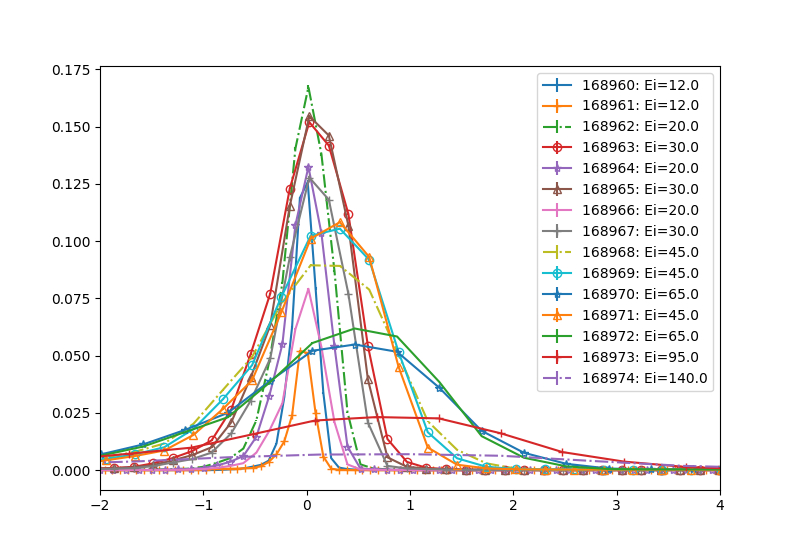

12.0
12.0
20.0
30.0
20.0
30.0
20.0
30.0
45.0
45.0
65.0
45.0
65.0
95.0
140.0


In [20]:
plt.figure(figsize=(8,5.5))

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 

for RunNumber, record in data_table.items()[:15]:
    Energy, Ei = record[:2]
    IE,  Q = record[-2:]
        
    print Energy
    if Energy<5: continue
    x,y,Err = IE
    # scale = 1./y.max()
    scale = 1.
    y=y*scale; Err=Err*scale
    # x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
    # y_interp = np.interp(x_interp, x,y)
    # y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    # plt.plot(x, y/np.sum(y), label=Chopper2)
    plt.errorbar(x,y, Err, fmt='-'+marker.next(), mfc='none', label='%s: Ei=%s' % (RunNumber, Energy))
    # plt.plot(x_interp, y_interp2, 'o')
# plt.xlim(-.3, .3)
plt.xlim(-2, 4)
plt.legend()

## Intensity vs E/Ei

<IPython.core.display.Javascript object>


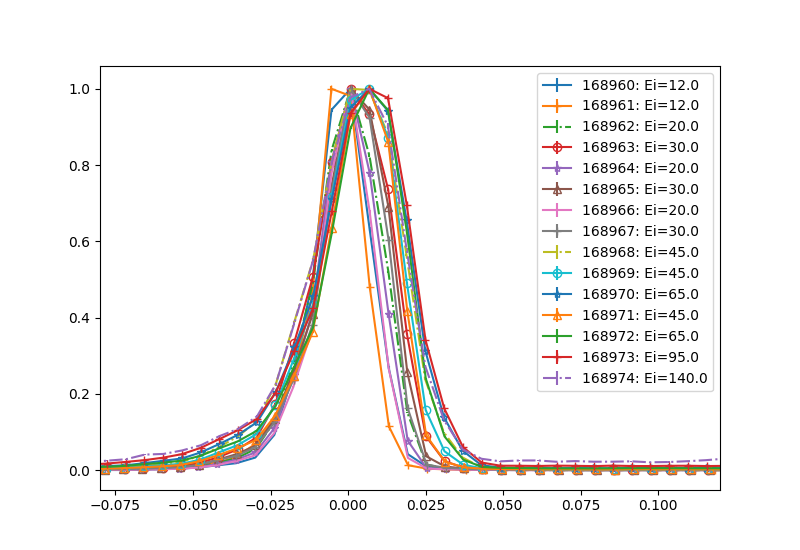

12.0
12.0
20.0
30.0
20.0
30.0
20.0
30.0
45.0
45.0
65.0
45.0
65.0
95.0
140.0


In [21]:
plt.figure(figsize=(8,5.5))

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 

for RunNumber, record in data_table.items()[:15]:
    Energy, Ei = record[:2]
    IE,  Q = record[-2:]
        
    print Energy
    if Energy<5: continue
    x,y,Err = IE
    scale = 1./y.max()
    # scale = 1.
    y=y*scale; Err=Err*scale
    x=x/Ei
    # x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
    # y_interp = np.interp(x_interp, x,y)
    # y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    # plt.plot(x, y/np.sum(y), label=Chopper2)
    plt.errorbar(x,y, Err, fmt='-'+marker.next(), mfc='none', label='%s: Ei=%s' % (RunNumber, Energy))
    # plt.plot(x_interp, y_interp2, 'o')
plt.xlim(-0.08, 0.12)
plt.legend()